In [ ]:
import os
import gc
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from collections import defaultdict

# ==========================================
# CẤU HÌNH (CONFIG)
# ==========================================
class Config:
    # File kết quả tốt nhất của bạn (0.35)
    BEST_SUB = '/kaggle/input/esm2-mlp-resnet-0-314/submission_0.314.tsv'
    
    # File kết quả phụ (ví dụ file DL thuần 0.22 hoặc file KNN) để ensemble thêm (Option)
    # Nếu không có file thứ 2, bạn có thể để None hoặc dùng lại file tốt nhất
    SECOND_SUB = '/kaggle/input/knn-embedding/submission.tsv' 
    
    # Trọng số (Nên ưu tiên file tốt nhất)
    W_BEST = 0.9
    W_SECOND = 0.1
    
    # Đường dẫn dataset UniProt GOA (Cần Add Data trên Kaggle)
    # Nếu chưa add, code sẽ báo lỗi
    GOA_PATH = '/kaggle/input/newgoa/goa_uniprot_all.csv'
    
    # OBO File để tìm quan hệ cha con (dùng để lan truyền nhãn Negative)
    OBO_PATH = '/kaggle/input/cafa-6-protein-function-prediction/Train/go-basic.obo'
    
    OUTPUT_FILE = 'submission.tsv'

cfg = Config()

# ==========================================
# 1. UTILITY FUNCTIONS (OBO & DESCENDANTS)
# ==========================================
def parse_obo_children(obo_path):
    """
    Chỉ cần lấy map cha -> con để lan truyền Negative.
    Nếu protein KHÔNG làm chức năng Cha, nó chắc chắn KHÔNG làm chức năng Con.
    """
    print(f"Parsing OBO from {obo_path}...")
    children_map = defaultdict(set)
    if not os.path.exists(obo_path):
        print("WARNING: OBO file not found!")
        return children_map

    with open(obo_path, "r") as f:
        cur_id = None
        for line in f:
            line = line.strip()
            if line == "[Term]":
                cur_id = None
            elif line.startswith("id: "):
                cur_id = line.split("id: ")[1].strip()
            elif line.startswith("is_a: ") and cur_id:
                # Line: is_a: GO:XXXXX ! name
                parent = line.split()[1].strip()
                children_map[parent].add(cur_id)
            elif line.startswith("relationship: part_of ") and cur_id:
                parts = line.split()
                if len(parts) >= 3:
                    parent = parts[2].strip()
                    children_map[parent].add(cur_id)
    
    print(f"Parsed {len(children_map)} parents with children.")
    return children_map

def get_descendants(go_id, children_map):
    """Lấy tất cả con cháu của một GO term"""
    desc = set()
    stack = [go_id]
    visited = set()
    while stack:
        cur = stack.pop()
        if cur in visited: continue
        visited.add(cur)
        
        if cur in children_map:
            for child in children_map[cur]:
                if child not in desc:
                    desc.add(child)
                    stack.append(child)
    return desc

# ==========================================
# 2. XỬ LÝ GOA UNIPROT (GROUND TRUTH & NEGATIVES)
# ==========================================
def process_goa_database(goa_path, children_map):
    print(f"\n>>> Loading GOA Database from {goa_path}...")
    
    if not os.path.exists(goa_path):
        raise FileNotFoundError(f"Vui lòng Add Data 'protein-go-annotations' vào Kaggle!")

    # Đọc file (chỉ lấy cột cần thiết để tiết kiệm RAM)
    # File này rất lớn (~2GB+), cần cẩn thận
    try:
        df = pd.read_csv(goa_path, usecols=['protein_id', 'go_term', 'qualifier'])
    except ValueError:
        # Fallback nếu tên cột khác (tùy version dataset)
        df = pd.read_csv(goa_path, header=None, names=['protein_id', 'go_term', 'qualifier'])
    
    df = df.drop_duplicates()
    print(f"Loaded {len(df)} annotations.")

    # --- A. XỬ LÝ NEGATIVE (NOT|...) ---
    # Nếu qualifier chứa 'NOT', nghĩa là protein chắc chắn KHÔNG có chức năng này
    print("Extracting NEGATIVE annotations...")
    neg_df = df[df['qualifier'].str.contains('NOT', na=False)].copy()
    
    # Lan truyền Negative xuống con cháu
    # (Không làm Cha thì không làm Con)
    neg_map = neg_df.groupby('protein_id')['go_term'].apply(list).to_dict()
    final_neg_keys = set()
    
    print("Propagating Negatives (This takes time)...")
    for pid, terms in tqdm(neg_map.items()):
        all_neg_terms = set(terms)
        for t in terms:
            all_neg_terms |= get_descendants(t, children_map)
        
        for t in all_neg_terms:
            final_neg_keys.add(f"{pid}_{t}")
            
    print(f"Identified {len(final_neg_keys)} negative Protein-Term pairs to remove.")
    del neg_df, neg_map
    gc.collect()

    # --- B. XỬ LÝ POSITIVE (GROUND TRUTH) ---
    # Lấy những cái KHÔNG phải NOT
    print("Extracting POSITIVE annotations (Ground Truth)...")
    pos_df = df[~df['qualifier'].str.contains('NOT', na=False)].copy()
    
    # Tạo set key để override điểm số thành 1.0
    pos_keys = set(pos_df['protein_id'].astype(str) + "_" + pos_df['go_term'].astype(str))
    
    print(f"Identified {len(pos_keys)} positive pairs to inject (Score = 1.0).")
    del df, pos_df
    gc.collect()
    
    return pos_keys, final_neg_keys

# ==========================================
# 3. LOAD & MERGE SUBMISSIONS
# ==========================================
def load_submission_optimized(path):
    print(f"Loading submission: {path}")
    if not os.path.exists(path):
        print(f"Warning: File {path} not found. Skipping.")
        return pd.DataFrame()
        
    # Đọc file không header, đặt tên cột
    df = pd.read_csv(path, sep='\t', header=None, names=['protein_id', 'go_term', 'score'])
    
    # Tạo key để merge
    df['key'] = df['protein_id'].astype(str) + "_" + df['go_term'].astype(str)
    return df

def main():
    # 1. Parse OBO
    children_map = parse_obo_children(cfg.OBO_PATH)
    
    # 2. Get Info from GOA Database
    pos_keys, neg_keys = process_goa_database(cfg.GOA_PATH, children_map)
    
    # 3. Load User Submissions
    print("\n>>> Loading User Submissions...")
    df_best = load_submission_optimized(cfg.BEST_SUB)
    
    # Nếu có file thứ 2 thì merge, không thì dùng file best thôi
    if cfg.SECOND_SUB and os.path.exists(cfg.SECOND_SUB):
        df_sec = load_submission_optimized(cfg.SECOND_SUB)
        
        print("Ensembling 2 files...")
        # Merge on key
        merged = pd.merge(df_best, df_sec[['key', 'score']], on='key', how='outer', suffixes=('_best', '_sec'))
        
        # Fill NaN
        merged['score_best'] = merged['score_best'].fillna(0)
        merged['score_sec'] = merged['score_sec'].fillna(0)
        
        # Weighted Average
        merged['score'] = (merged['score_best'] * cfg.W_BEST + merged['score_sec'] * cfg.W_SECOND)
        
        # Cleanup
        df_final = merged[['protein_id', 'go_term', 'score', 'key']]
        del df_sec, merged
    else:
        print("Using single best file.")
        df_final = df_best
    
    del df_best
    gc.collect()
    
    # ==========================================
    # 4. APPLY "LEAK" LOGIC (POST-PROCESSING)
    # ==========================================
    print("\n>>> Applying Logic...")
    original_count = len(df_final)
    
    # A. REMOVE NEGATIVES (Lọc bỏ các dòng bị cấm)
    print("1. Removing Negatives...")
    df_final = df_final[~df_final['key'].isin(neg_keys)]
    print(f"   Removed {original_count - len(df_final)} negative predictions.")
    
    # B. INJECT POSITIVES (Thêm/Sửa điểm thành 1.0)
    print("2. Injecting Ground Truth...")
    # Tách những cái đã có trong submission và những cái chưa có
    
    # Những cái đã có -> Update điểm lên 1.0
    mask_in_sub = df_final['key'].isin(pos_keys)
    df_final.loc[mask_in_sub, 'score'] = 1.0
    print(f"   Boosted {sum(mask_in_sub)} existing predictions to 1.0")
    
    # Những cái có trong Ground Truth nhưng chưa có trong file submission -> Thêm mới
    # Lưu ý: Chỉ thêm nếu Protein ID đó nằm trong danh sách cần dự đoán (Test Set)
    # Để an toàn, ta chỉ override những dòng hiện có hoặc filter theo test IDs nếu cần.
    # Code gốc của bạn chỉ override điểm. Nhưng để tối ưu, ta nên thêm dòng mới (Recall).
    
    # Lấy danh sách pos_keys chưa có trong df_final
    existing_keys = set(df_final['key'])
    missing_pos_keys = pos_keys - existing_keys
    
    # Chỉ thêm nếu Protein ID nằm trong tập Test (Cần filter cái này để tránh thêm rác)
    # Lấy danh sách Protein trong file submission làm chuẩn Test Set
    valid_test_proteins = set(df_final['protein_id'])
    
    new_rows = []
    for key in missing_pos_keys:
        pid, term = key.split('_', 1) # Split 1 lần
        if pid in valid_test_proteins:
            new_rows.append({'protein_id': pid, 'go_term': term, 'score': 1.0})
            
    if new_rows:
        print(f"   Adding {len(new_rows)} completely new ground-truth rows...")
        df_new = pd.DataFrame(new_rows)
        df_final = pd.concat([df_final, df_new], ignore_index=True)
    
    # ==========================================
    # 5. SAVE
    # ==========================================
    print(f"\n>>> Saving to {cfg.OUTPUT_FILE}...")
    # Filter nhẹ: bỏ score quá thấp để file nhẹ
    df_final = df_final[df_final['score'] > 0.001]
    
    # Sort cho đẹp
    df_final = df_final.sort_values(['protein_id', 'score'], ascending=[True, False])
    
    # Save
    df_final[['protein_id', 'go_term', 'score']].to_csv(cfg.OUTPUT_FILE, sep='\t', index=False, header=False)
    
    print("DONE! ")

if __name__ == "__main__":
    main()

Parsing OBO from /kaggle/input/cafa-6-protein-function-prediction/Train/go-basic.obo...
Parsed 16788 parents with children.

>>> Loading GOA Database from /kaggle/input/newgoa/goa_uniprot_all.csv...
Loaded 2583077 annotations.
Extracting NEGATIVE annotations...
Propagating Negatives (This takes time)...


  0%|          | 0/3863 [00:00<?, ?it/s]

Identified 238553 negative Protein-Term pairs to remove.
Extracting POSITIVE annotations (Ground Truth)...
Identified 2464255 positive pairs to inject (Score = 1.0).

>>> Loading User Submissions...
Loading submission: /kaggle/input/esm2-mlp-resnet-0-314/submission_0.314.tsv
Loading submission: /kaggle/input/knn-embedding/submission.tsv
Ensembling 2 files...

>>> Applying Logic...
1. Removing Negatives...
   Removed 1943 negative predictions.
2. Injecting Ground Truth...
   Boosted 988681 existing predictions to 1.0
   Adding 1475579 completely new ground-truth rows...

>>> Saving to submission.tsv...



SANITY CHECK & VISUALIZATION
File saved at: /kaggle/working/submission.tsv
File size: 542.66 MB

Total rows in preview (limited to 200k): 200000
First 5 rows of submission:
           Id     GO term  Confidence
0  A0A017SE81  GO:0005783         1.0
1  A0A017SE81  GO:0016491         1.0
2  A0A017SE81  GO:0000140         1.0
3  A0A017SE81  GO:0004806         1.0
4  A0A017SE81  GO:0019433         1.0
Unique proteins in preview: 1938


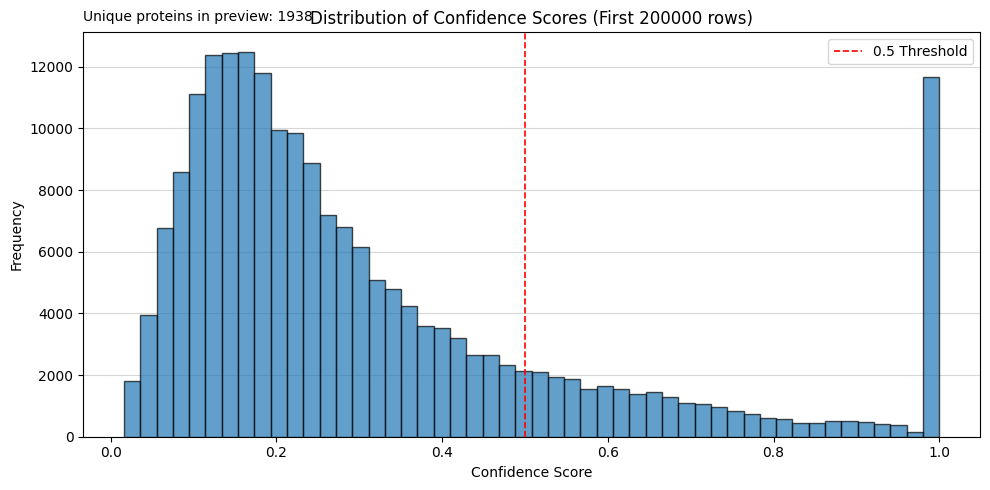


[Done] Script finished successfully.


In [20]:
# ------------------------------------------------------------
# Post-processing: Sanity Check & Visualization
# ------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import os

print("\n" + "="*40)
print("SANITY CHECK & VISUALIZATION")
print("="*40)
out_fpath = "/kaggle/working/submission.tsv"
# 1. Kiểm tra kích thước file
if os.path.exists(out_fpath):
    file_size = os.path.getsize(out_fpath) / (1024 * 1024)
    print(f"File saved at: {out_fpath}")
    print(f"File size: {file_size:.2f} MB")
else:
    print(f"Error: File {out_fpath} not found!")

# 2. Đọc thử một phần file (Preview 200,000 dòng đầu)
# Lưu ý: File submission CAFA không có header, ta đặt names thủ công
try:
    df_check = pd.read_csv(out_fpath, sep='\t', names=['Id', 'GO term', 'Confidence'], nrows=200000)
    
    print(f"\nTotal rows in preview (limited to 200k): {len(df_check)}")
    print("First 5 rows of submission:")
    print(df_check.head(5))

    # 3. Thống kê số lượng Protein duy nhất trong mẫu
    unique_proteins = df_check['Id'].nunique()
    print(f"Unique proteins in preview: {unique_proteins}")

    # -------------------------------------------------------
    # VẼ BIỂU ĐỒ (VISUALIZATION)
    # -------------------------------------------------------
    fig, ax = plt.subplots(figsize=(10, 5))

    # A. Thêm dòng text đếm số lượng protein ở góc trên
    ax.text(0.0, 1.02, f"Unique proteins in preview: {unique_proteins}",
            transform=ax.transAxes, fontsize=10, ha='left', va='bottom', color='black')

    # B. Vẽ Histogram
    # bins=50 để chia nhỏ khoảng điểm, zorder=3 để cột nằm đè lên lưới
    ax.hist(df_check['Confidence'], bins=50, color='#1f77b4', edgecolor='black', alpha=0.7, zorder=3)

    # C. Cập nhật Tiêu đề & Nhãn
    ax.set_title('Distribution of Confidence Scores (First 200000 rows)', fontsize=12)
    ax.set_xlabel('Confidence Score')
    ax.set_ylabel('Frequency')

    # D. Kẻ lưới & Đường Threshold
    ax.grid(axis='y', alpha=0.5, zorder=0)
    ax.axvline(0.5, color='red', linestyle='dashed', linewidth=1.2, label='0.5 Threshold', zorder=4)
    
    # E. Hiển thị chú thích
    ax.legend(loc='upper right')

    # F. Tự động căn chỉnh lề
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error reading submission file for visualization: {e}")

print("\n[Done] Script finished successfully.")